## Argparse Setup

In [1]:
# Imports
import os
import sys
import torch
import numpy as np
from matplotlib import pyplot as plt

# Add the setup_data_vars function as we will need it to find the directory for the training data.
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..'))
if not dir1 in sys.path: sys.path.append(dir1)

from utils.environment import setup_data_vars
setup_data_vars()

dir2 = os.path.abspath(os.path.join(os.path.abspath(''), '..', 'SAM_Med/' '0_utils'))
if not dir2 in sys.path: sys.path.append(dir2)

from dataset import SAM_Dataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [2]:
anatomy = 'CTVn'
# patient_id = 28
# slice_number = 232
# axis = 1

lowres = True
save_dir = os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', anatomy)
checkpoint_path = os.path.join(os.environ['PROJECT_DIR'], 'models', 'MedSAM', 'work_dir', 'MedSAM', 'medsam_vit_b.pth')
model_path = os.path.join(save_dir, 'checkpoint_best.pth')
data_split = os.path.join(save_dir, 'data_splits.json')
img_dir = os.path.join(os.environ.get('MedSAM_preprocessed_lowres'), 'imgs')
gt_dir = os.path.join(os.environ.get('MedSAM_preprocessed_lowres'), 'gts', anatomy)
batch_size = 1
num_workers = 16

use_boxes = True
use_positive_points = False

assert os.path.exists(model_path), f"Model path {model_path} does not exist."
assert os.path.exists(data_split), f"Data split {data_split} does not exist."
assert os.path.exists(img_dir), f"Raw data {img_dir} does not exist."
assert os.path.exists(gt_dir), f"Ground truth data {gt_dir} does not exist."

In [3]:
# setup dataset
dataset = SAM_Dataset(img_dir, gt_dir, list(range(0, 101)))

Dataset size (32.9 GiB) exceeds cache limit (20 GiB). Allocating space to cache 20479 / 33680 samples.


## Set up Fine-Tuning nn Module

In [4]:
from medsam_model import MedSAM
from checkpoint_handler import CheckpointHandler

In [5]:
from segment_anything import sam_model_registry
base_model = sam_model_registry["vit_b"](checkpoint=checkpoint_path)


cph = CheckpointHandler(save_dir, checkpoint_path, device)

if cph.checkpoint_exists():
    MedSAM_model, _, epoch, best_loss = cph.load_checkpoint()
    print(f'Loaded the model for anatomy {anatomy} from epoch {epoch}')

MedSAM_model_base, _ = cph.load_base_checkpoint()
print('Loaded baseline model')

Loaded the model for anatomy CTVn from epoch 101
Loaded baseline model


## Load up the specific example from the dataset

In [13]:
from torch.utils.data import DataLoader

dl = DataLoader(dataset, batch_size=1, num_workers=num_workers, shuffle=True)
dl = iter(dl)

patient_id = 28
slice_number = 232
axis = 1

batch = dataset.get_specific_sample(patient_id, axis, slice_number)
# batch = next(dl)

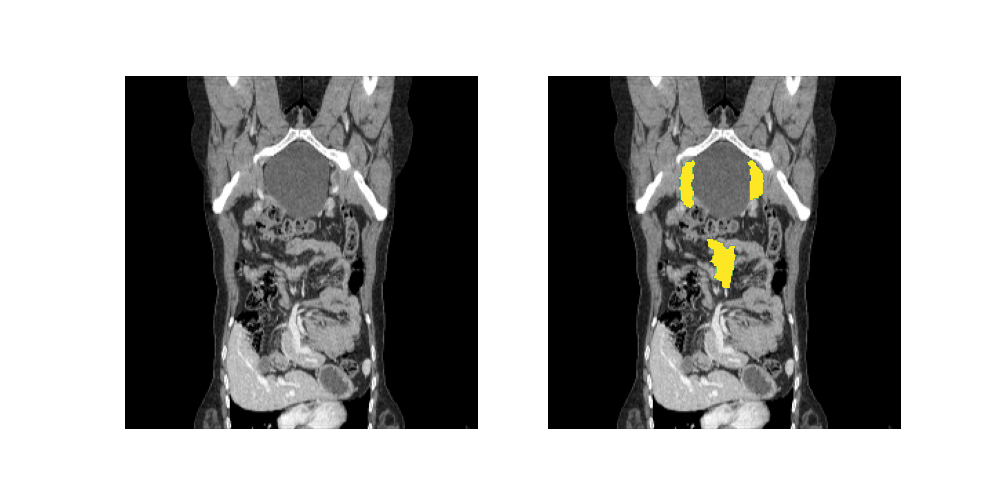

In [14]:
# FOR A RANDOM BATCH OF 1
image = batch["image"].to(device)
gt2D = batch["gt2D"].to(device)

if len(image.shape) == 3:
    image = image.unsqueeze(0)
    gt2D = gt2D.unsqueeze(0)

# coords_torch = batch["coords"].squeeze().to(device) # ([B, Ps, 2])
boxes_torch = batch["boxes"].squeeze().reshape(batch_size, -1, 4).to(device) # ([B, Ps, 4])

medsam_preds = []
medsam_segs = []

nrows = 1
ncols = 2

import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 5))

image_256 = torch.nn.functional.interpolate(image, size=(256, 256), mode='bilinear', align_corners=False)
axs[0].imshow(image_256.cpu().numpy().squeeze()[0], cmap='gray')
axs[1].imshow(image_256.cpu().numpy().squeeze()[0], cmap='gray')
axs[0].axis('off')


axs[1].imshow(gt2D.cpu().numpy().squeeze(), cmap='viridis', alpha=np.where(gt2D.cpu().numpy().squeeze() > 0, 1, 0).astype(np.float32))
axs[1].axis('off')

plt.show()

In [15]:
import torch
from torchvision.transforms import ToPILImage
from PIL import Image

to_pil = ToPILImage()
img_pil = to_pil(image[0])

img_pil.save('demo.png')

In [16]:
from demo import BboxPromptDemo

Button(description='clear', style=ButtonStyle())

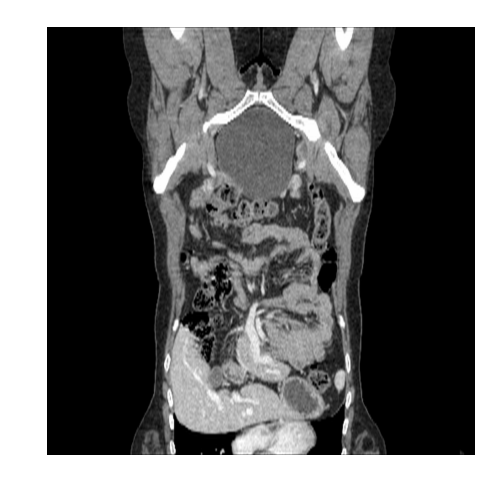

Button(description='save', style=ButtonStyle())

In [17]:
%matplotlib widget
bbox_prompt_demo = BboxPromptDemo(MedSAM_model_base)
bbox_prompt_demo.show('demo.png')

Button(description='clear', style=ButtonStyle())

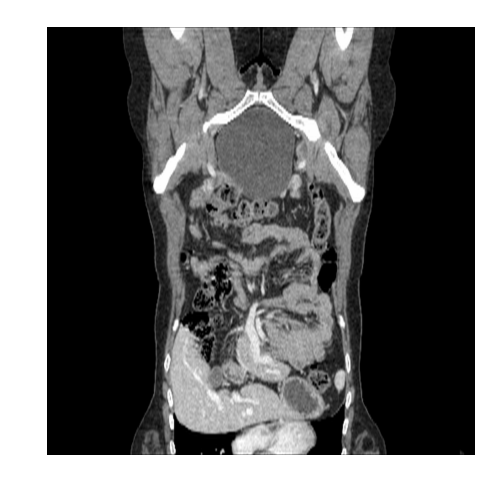

Button(description='save', style=ButtonStyle())

: 

In [18]:
%matplotlib widget
bbox_prompt_demo = BboxPromptDemo(MedSAM_model)
bbox_prompt_demo.show('demo.png')